In [11]:
import pandas as pd
import dotenv
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
import psycopg2

In [12]:
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

dotenv.load_dotenv()
# Configuração da conexão
config = {
    "host":     os.getenv("host_gcp"),
    "dbname":   "beny",
    "user":     os.getenv("meuUser"),
    "password": os.getenv("minhaSenha"),
    "port":     os.getenv("port_gcp")
}

try:
    # Conectar ao banco e criar cursor
    conn = psycopg2.connect(**config)
    cursor = conn.cursor()
    print("Conectado!")

    # cursor.execute("SELECT table_name FROM information_schema.tables WHERE table_schema = 'public';")
    # tables = cursor.fetchall()
    # print(tables)

    #Executar a query na tabela vendas
    query = "SELECT * FROM vendas;"
    cursor.execute(query)
    # Obter todas as linhas retornadas
    linhas = cursor.fetchall()
    # Obter os nomes das colunas a partir do cursor.description
    colunas = [desc[0] for desc in cursor.description]
    # Criar o DataFrame com os dados e as colunas
    df_vendas = pd.DataFrame(linhas, columns=colunas)

    query = "SELECT * FROM clientes;"
    cursor.execute(query)
    linhas = cursor.fetchall()
    colunas = [desc[0] for desc in cursor.description]
    df_clientes = pd.DataFrame(linhas, columns=colunas)

    query = "SELECT * FROM clientespessoafisica;"
    cursor.execute(query)
    linhas = cursor.fetchall()
    colunas = [desc[0] for desc in cursor.description]
    df_clientes_PF = pd.DataFrame(linhas, columns=colunas)
    
    #Exibir as primeiras linhas do DataFrame vendas e clientes
    print("TABLE Vendas")
    print(df_vendas.head())
    
    print("TABLE Clientes")
    print(df_clientes.head())

    print("TABLE Clientes")
    print(df_clientes_PF.head())
    
    # Fechar cursor e conexão
    cursor.close()
    conn.close()
    print("fechando cursor e conn")
except Exception as e:
    print(f"Erro ao conectar ou executar a query: {e}")

Conectado!
TABLE Vendas
   id_venda id_original  id_cliente data_compra total_item
0         1    47057992      104347  2021-02-22    1589.00
1         2    13148533      136322  2021-02-18     158.50
2         3    42074841      155862  2021-02-09    1716.50
3         4    43065729       70630  2021-03-15    1342.10
4         5    13146799       90404  2021-01-13    2617.18
TABLE Clientes
   id_cliente tipo_cliente                   email       telefone  \
0      179663            J  l_stedesco@hotmail.com  92 99128-0571   
1      179655            F               nt@nt.com  92 98152-7729   
2      179644            F      cesarvalmir@me.com  95 99971-1600   
3      179664            F               nt@nt.com  92 99612-9803   
4      179647            F               nt@nt.com  92 99344-6160   

                                   endereco       cep   cidade estado  
0                    AVENIDA COSME FERREIRA  69075775  11240.0     AM  
1    AVENIDA RAMOS FERREIRA - ATÉ 1111/1112  690

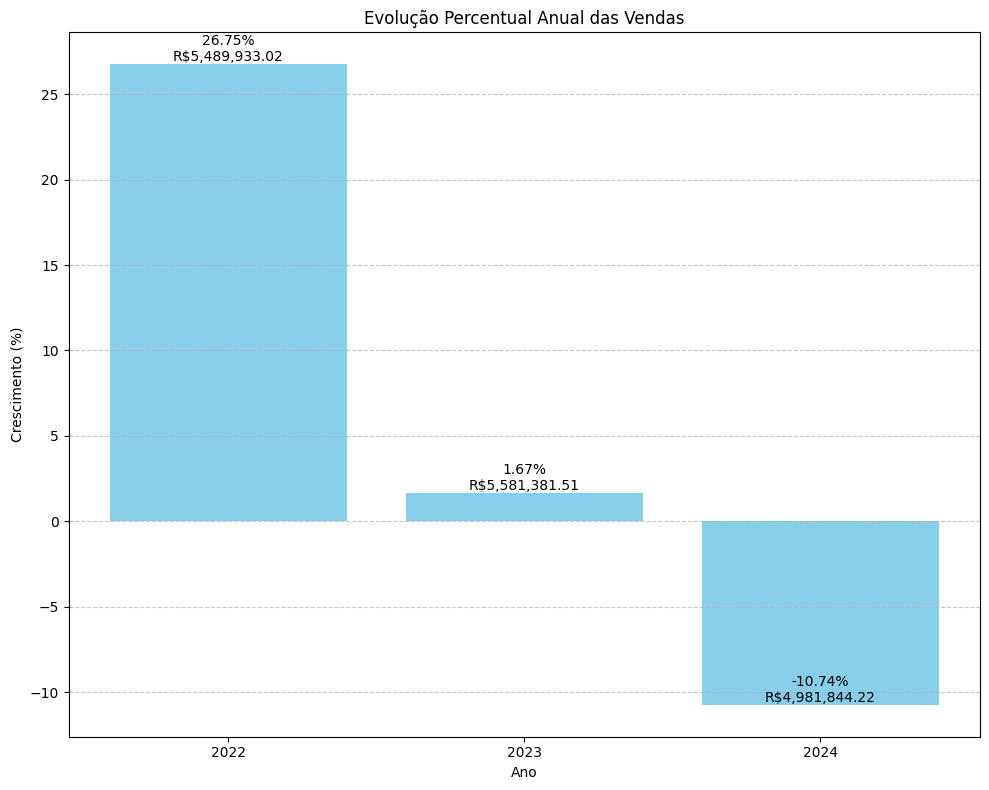

In [13]:
df_vendas['data_compra'] = pd.to_datetime(df_vendas['data_compra'])
df_vendas['total_item'] = pd.to_numeric(df_vendas['total_item'], errors='coerce')
df_vendas = df_vendas.merge(df_clientes[['id_cliente', 'tipo_cliente']], on='id_cliente', how='left')
df_vendas = df_vendas[df_vendas['tipo_cliente'] == 'J']

# Criar a coluna Ano
df_vendas['Ano'] = df_vendas['data_compra'].dt.year

# Agregar os dados por Ano, somando o total de vendas
df_anual = df_vendas.groupby('Ano')['total_item'].sum().reset_index()

# Calcular a evolução percentual anual (variação de um ano para o outro)
df_anual['Evolucao (%)'] = df_anual['total_item'].pct_change() * 100

# Exportar os dados para um arquivo Excel
df_anual.to_excel('faturamento_anual.xlsx', index=False)

# Plotar o gráfico de evolução percentual anual com labels
plt.figure(figsize=(10,8))
bars = plt.bar(df_anual['Ano'].astype(str), df_anual['Evolucao (%)'], color='skyblue')
plt.title('Evolução Percentual Anual das Vendas')
plt.xlabel('Ano')
plt.ylabel('Crescimento (%)')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adicionar os labels com a porcentagem e o valor faturado em cada barra
for bar, perc, tot in zip(bars, df_anual['Evolucao (%)'], df_anual['total_item']):
    height = bar.get_height()
    # Cria uma label com duas linhas: a primeira para a porcentagem e a segunda para o faturamento
    label = f'{perc:.2f}%\nR${tot:,.2f}'
    plt.text(bar.get_x() + bar.get_width()/2, height, label, ha='center', va='bottom')

plt.tight_layout()
plt.show()

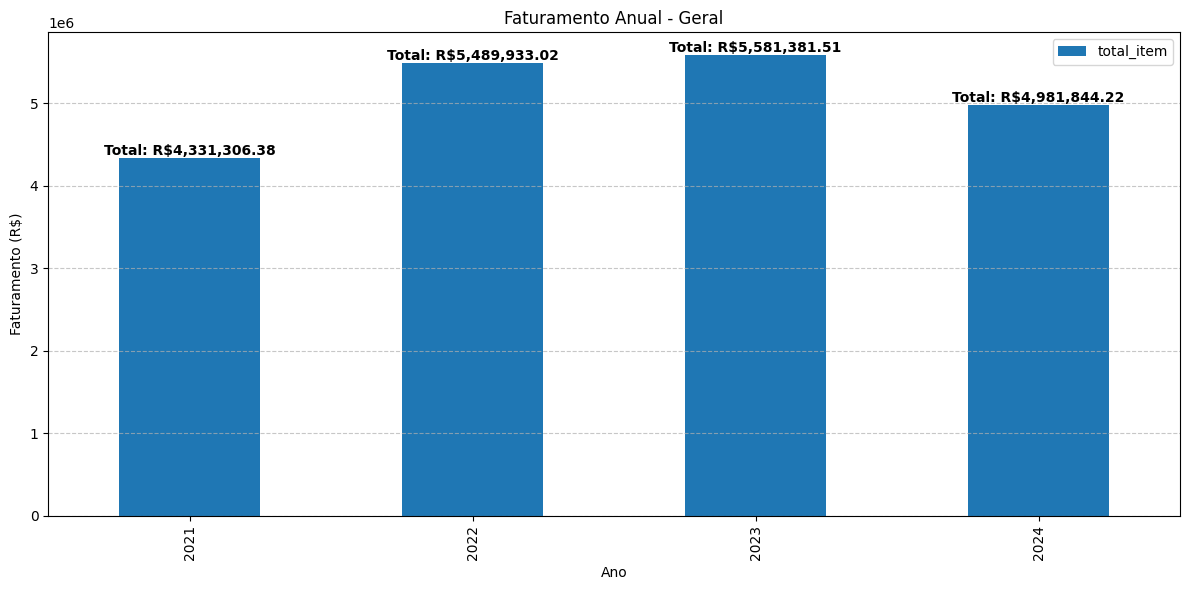

In [14]:
# --- Gráfico Geral: Faturamento Anual ---

# Agregar os dados por Ano (sem considerar grupo_cliente)
df_ano = df_vendas.groupby('Ano')['total_item'].sum().reset_index()
df_ano.columns = ['Ano', 'total_item']

# Exportar os dados para um arquivo Excel
df_ano.to_excel('faturamento_anual_geral.xlsx', index=False)

# Plotar o gráfico de barras
ax = df_ano.plot(x='Ano', y='total_item', kind='bar', figsize=(12,6), color='#1f77b4')
plt.title('Faturamento Anual - Geral')
plt.xlabel('Ano')
plt.ylabel('Faturamento (R$)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
# Adicionar label com o valor total no topo de cada barra
for i, row in enumerate(df_ano.itertuples()):
    ax.text(i, row.total_item, f'Total: R${row.total_item:,.2f}', ha='center', va='bottom', fontweight='bold')
plt.tight_layout()
plt.show()

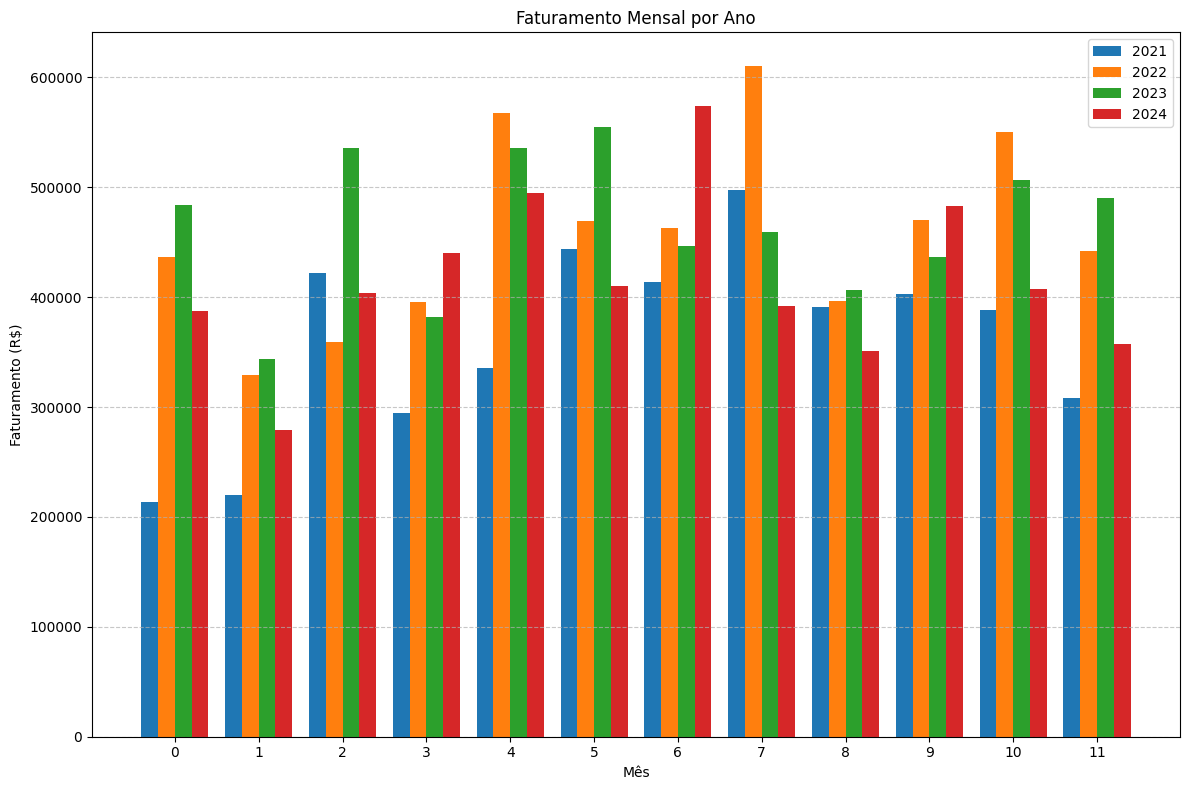

In [15]:
df_vendas['Mês'] = df_vendas['data_compra'].dt.month

# Agrupar por Ano e Mês somando o total_item
df_pivot = df_vendas.groupby(['Ano', 'Mês'])['total_item'].sum().reset_index()
df_pivot = df_pivot.pivot(index='Mês', columns='Ano', values='total_item')
df_pivot.reset_index(inplace=True)
df_pivot.to_excel('faturamento_mensal.xlsx', index=False)

anos = [2021, 2022, 2023, 2024]  # anos de interesse
fig, ax = plt.subplots(figsize=(12, 8))

# Configurar a largura das barras e a posição no eixo x
width = 0.2  
x = np.arange(len(df_pivot.index))  # índices para os meses
num_anos = len(anos)

# Plotar as barras para cada ano com deslocamentos para que fiquem lado a lado
for i, ano in enumerate(anos):
    # Caso algum ano não tenha dados para determinados meses, use 0 como valor padrão
    valores = df_pivot[ano].fillna(0)
    ax.bar(x + i * width, valores, width=width, label=str(ano))

# Configurar os rótulos do eixo x para que fiquem centralizados
ax.set_xticks(x + width * (num_anos - 1) / 2)
ax.set_xticklabels(df_pivot.index)
ax.set_title('Faturamento Mensal por Ano')
ax.set_xlabel('Mês')
ax.set_ylabel('Faturamento (R$)')
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()